Importing Libraries and Packages:

In [1]:
!pip install tensorflow
!pip install optuna
import tensorflow as tf
import struct
import os
import logging
import optuna
import optuna.visualization as vis
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, LeakyReLU, Activation, Dropout , Conv2D ,Conv2DTranspose , BatchNormalization ,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import numpy as np

# Set TensorFlow logging level to suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Set logging level to suppress TensorFlow warnings except for critical ones
tf.get_logger().setLevel(logging.ERROR) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Loading, Preprocessing & Splitting Data**

In [3]:
#Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Concatenate images and labels
all_images = np.concatenate((x_train, x_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

# scalling
all_images = all_images.reshape(all_images.shape[0], 28, 28, 1)
all_images = all_images.astype('float32')
all_images = all_images / 255.0

#Split into training,validation and test datasets in 70 , 15 and 15 %
train_X,rem_X,train_Y,rem_Y = train_test_split(all_images,all_labels,test_size=0.3,random_state=13)
val_X,test_X,val_Y,test_Y = train_test_split(rem_X,rem_Y,test_size=0.5,random_state=13)

11490434/11490434 [==============================] - 0s 0us/step


# **Building the Autoencoder Model :**

In [4]:
class Autoencoder(Model):
    def __init__(self,latent_dim,conv_layers,kernel_size,filters,shape,dropout_rate):
        super(Autoencoder, self).__init__()

        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder_layers = []

        #First layer in decoder has the same dimension as the last layer in encoder (original size halved as many times as we applied upsampling,2 here)
        last_layer = shape[0] // (2 ** 2)

        #The flattened layer will be the inner product of the last layer in encoder that had dimensions (last_layer,last_layer,last filter size)
        flattened_dim = last_layer * last_layer * filters[conv_layers-1]

        self.decoder_layers = [Dense(flattened_dim, activation='relu'),
                               Reshape((last_layer,last_layer,filters[conv_layers-1]))]

        for layer in range(conv_layers) :

          #add the convolutional and maxpooling layer in the encoder's list
          self.encoder_layers.append(Conv2D(filters=filters[layer], kernel_size=kernel_size, activation='relu', padding='same'))
          self.encoder_layers.append(BatchNormalization())
          if(layer < conv_layers - 1) :
            #add the convolutional layer in the decoder's list with the opposite order of the filters
            self.decoder_layers.append(Conv2DTranspose(filters=filters[conv_layers-layer-1], kernel_size=kernel_size, activation='relu', padding='same'))
            self.decoder_layers.append(BatchNormalization())
            #We only apply maxpooling in the first 2 layers because otherwise we can't reconstruct the vector with the appropriate dimensions
            if(layer <=  1) :
                self.encoder_layers.append(MaxPooling2D((2, 2), padding="same"))
                self.decoder_layers.append(UpSampling2D((2, 2), interpolation='nearest'))
            self.decoder_layers.append(Dropout(dropout_rate))

          self.encoder_layers.append(Dropout(dropout_rate))

        self.encoder_layers.append(Flatten())
        self.encoder_layers.append(Dense(self.latent_dim, activation='relu'))

        #In the last layer of the decoder we apply the sigmoid function
        self.decoder_layers.append(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same'))

        self.encoder = tf.keras.Sequential(self.encoder_layers)
        self.decoder = tf.keras.Sequential(self.decoder_layers)

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# **Hyperparameter Tuning:**

In [5]:
# Disable Optuna trial output
optuna.logging.set_verbosity(optuna.logging.WARNING)  

shape = (28,28,1)
predefined_filters =[[32, 64, 128],[32,64,128,256],[16,32,64,128],[16,32,64,128,256]]

def objective(trial):
    epoch = trial.suggest_categorical('epoch',[10,15,20])
    batch = trial.suggest_categorical('batch', [64,128,256])
    dim = trial.suggest_categorical('dim',[5,10,20,30])
    kernel = trial.suggest_categorical('kernel', [(3, 3), (5, 5), (7, 7)])
    filters = trial.suggest_categorical('filters', predefined_filters)
    rate = trial.suggest_categorical('rate', [0.5,0.6,0.7])

    autoencoder = Autoencoder(dim, len(filters), kernel, filters, shape, rate)
    autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = autoencoder.fit(train_X, train_X,
                              epochs=epoch,
                              shuffle=True,
                              batch_size=batch,
                              callbacks=[early_stopping],
                              validation_data=(val_X, val_X))
    val_loss = history.history['val_loss'][-1]
    return val_loss

study = optuna.create_study(direction='minimize', study_name='my_study_name')
study.optimize(objective, n_trials=25)

/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (7, 7) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but conta

Epoch 1/10


2024-01-08 09:24:30.130123: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder/sequential/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 26s 20ms/step - loss: 0.0566 - accuracy: 0.7892 - val_loss: 0.0347 - val_accuracy: 0.7998
Epoch 2/10
766/766 [==============================] - 14s 18ms/step - loss: 0.0334 - accuracy: 0.8020 - val_loss: 0.0242 - val_accuracy: 0.8055
Epoch 3/10
766/766 [==============================] - 14s 18ms/step - loss: 0.0279 - accuracy: 0.8052 - val_loss: 0.0219 - val_accuracy: 0.8050
Epoch 4/10
766/766 [==============================] - 14s 18ms/step - loss: 0.0260 - accuracy: 0.8063 - val_loss: 0.0254 - val_accuracy: 0.8019
Epoch 5/10
766/766 [==============================] - 14s 18ms/step - loss: 0.0244 - accuracy: 0.8071 - val_loss: 0.0181 - val_accuracy: 0.8091
Epoch 6/10
766/766 [==============================] - 14s 18ms/step - loss: 0.0228 - accuracy: 0.8080 - val_loss: 0.0171 - val_accuracy: 0.8090
Epoch 7/10
766/766 [==============================] - 14s 18ms/step - loss: 0.0218 - accuracy: 0.8085 - val_loss: 0.0157 - val_accuracy: 0.8108
Epo

2024-01-08 09:27:03.197963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_1/sequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 35s 67ms/step - loss: 0.0712 - accuracy: 0.7853 - val_loss: 0.0744 - val_accuracy: 0.7982
Epoch 2/10
383/383 [==============================] - 24s 61ms/step - loss: 0.0572 - accuracy: 0.7913 - val_loss: 0.0527 - val_accuracy: 0.7982
Epoch 3/10
383/383 [==============================] - 24s 61ms/step - loss: 0.0490 - accuracy: 0.7942 - val_loss: 0.0449 - val_accuracy: 0.7931
Epoch 4/10
383/383 [==============================] - 23s 61ms/step - loss: 0.0463 - accuracy: 0.7952 - val_loss: 0.0396 - val_accuracy: 0.8036
Epoch 5/10
383/383 [==============================] - 24s 61ms/step - loss: 0.0428 - accuracy: 0.7970 - val_loss: 0.0382 - val_accuracy: 0.8022
Epoch 6/10
383/383 [==============================] - 24s 61ms/step - loss: 0.0405 - accuracy: 0.7977 - val_loss: 0.0379 - val_accuracy: 0.8031
Epoch 7/10
383/383 [==============================] - 23s 61ms/step - loss: 0.0376 - accuracy: 0.7995 - val_loss: 0.0316 - val_accuracy: 0.8047
Epo

2024-01-08 09:31:28.605758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_2/sequential_4/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 18s 30ms/step - loss: 0.0609 - accuracy: 0.7855 - val_loss: 0.0658 - val_accuracy: 0.8088
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0326 - accuracy: 0.8027 - val_loss: 0.0230 - val_accuracy: 0.8106
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0257 - accuracy: 0.8065 - val_loss: 0.0181 - val_accuracy: 0.8120
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0219 - accuracy: 0.8086 - val_loss: 0.0154 - val_accuracy: 0.8128
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0197 - accuracy: 0.8097 - val_loss: 0.0147 - val_accuracy: 0.8131
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0183 - accuracy: 0.8104 - val_loss: 0.0113 - val_accuracy: 0.8135
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0170 - accuracy: 0.8110 - val_loss: 0.0107 - val_accuracy: 0.8138
Epo

2024-01-08 09:35:09.601054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_3/sequential_6/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 19s 17ms/step - loss: 0.0614 - accuracy: 0.7870 - val_loss: 0.0395 - val_accuracy: 0.8087
Epoch 2/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0341 - accuracy: 0.8017 - val_loss: 0.0238 - val_accuracy: 0.8106
Epoch 3/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0275 - accuracy: 0.8054 - val_loss: 0.0197 - val_accuracy: 0.8111
Epoch 4/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0245 - accuracy: 0.8070 - val_loss: 0.0166 - val_accuracy: 0.8120
Epoch 5/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0219 - accuracy: 0.8083 - val_loss: 0.0148 - val_accuracy: 0.8124
Epoch 6/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0203 - accuracy: 0.8091 - val_loss: 0.0132 - val_accuracy: 0.8126
Epoch 7/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0191 - accuracy: 0.8097 - val_loss: 0.0116 - val_accuracy: 0.8123
Epo

2024-01-08 09:38:30.028152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_4/sequential_8/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 10s 23ms/step - loss: 0.0916 - accuracy: 0.7703 - val_loss: 0.0974 - val_accuracy: 0.8083
Epoch 2/20
192/192 [==============================] - 4s 21ms/step - loss: 0.0637 - accuracy: 0.7882 - val_loss: 0.0704 - val_accuracy: 0.8085
Epoch 3/20
192/192 [==============================] - 4s 21ms/step - loss: 0.0516 - accuracy: 0.7918 - val_loss: 0.0602 - val_accuracy: 0.8088
Epoch 4/20
192/192 [==============================] - 4s 21ms/step - loss: 0.0473 - accuracy: 0.7945 - val_loss: 0.0404 - val_accuracy: 0.8049
Epoch 5/20
192/192 [==============================] - 4s 21ms/step - loss: 0.0449 - accuracy: 0.7956 - val_loss: 0.0389 - val_accuracy: 0.8038
Epoch 6/20
192/192 [==============================] - 4s 21ms/step - loss: 0.0423 - accuracy: 0.7975 - val_loss: 0.0361 - val_accuracy: 0.8049
Epoch 7/20
192/192 [==============================] - 4s 21ms/step - loss: 0.0398 - accuracy: 0.7986 - val_loss: 0.0353 - val_accuracy: 0.8071
Epoch 8/2

2024-01-08 09:40:55.362552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_5/sequential_10/dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 17ms/step - loss: 0.0788 - accuracy: 0.7902 - val_loss: 0.0705 - val_accuracy: 0.8083
Epoch 2/15
766/766 [==============================] - 12s 16ms/step - loss: 0.0679 - accuracy: 0.7973 - val_loss: 0.0647 - val_accuracy: 0.8060
Epoch 3/15
766/766 [==============================] - 12s 16ms/step - loss: 0.0632 - accuracy: 0.7954 - val_loss: 0.0607 - val_accuracy: 0.8038
Epoch 4/15
766/766 [==============================] - 12s 16ms/step - loss: 0.0564 - accuracy: 0.7928 - val_loss: 0.0527 - val_accuracy: 0.7993
Epoch 5/15
766/766 [==============================] - 12s 16ms/step - loss: 0.0464 - accuracy: 0.7949 - val_loss: 0.0374 - val_accuracy: 0.8012
Epoch 6/15
766/766 [==============================] - 13s 16ms/step - loss: 0.0401 - accuracy: 0.7981 - val_loss: 0.0333 - val_accuracy: 0.8038
Epoch 7/15
766/766 [==============================] - 12s 16ms/step - loss: 0.0378 - accuracy: 0.7995 - val_loss: 0.0323 - val_accuracy: 0.8040
Epo

2024-01-08 09:44:09.890901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_6/sequential_12/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 13s 20ms/step - loss: 0.0752 - accuracy: 0.7851 - val_loss: 0.0612 - val_accuracy: 0.8077
Epoch 2/10
383/383 [==============================] - 7s 18ms/step - loss: 0.0549 - accuracy: 0.7932 - val_loss: 0.0407 - val_accuracy: 0.7947
Epoch 3/10
383/383 [==============================] - 7s 18ms/step - loss: 0.0426 - accuracy: 0.7976 - val_loss: 0.0326 - val_accuracy: 0.8044
Epoch 4/10
383/383 [==============================] - 7s 18ms/step - loss: 0.0373 - accuracy: 0.8003 - val_loss: 0.0269 - val_accuracy: 0.8047
Epoch 5/10
383/383 [==============================] - 7s 18ms/step - loss: 0.0318 - accuracy: 0.8032 - val_loss: 0.0232 - val_accuracy: 0.8088
Epoch 6/10
383/383 [==============================] - 7s 18ms/step - loss: 0.0284 - accuracy: 0.8050 - val_loss: 0.0198 - val_accuracy: 0.8096
Epoch 7/10
383/383 [==============================] - 7s 18ms/step - loss: 0.0254 - accuracy: 0.8065 - val_loss: 0.0180 - val_accuracy: 0.8105
Epoch 8/1

2024-01-08 09:45:27.430768: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_7/sequential_14/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 25s 80ms/step - loss: 0.0721 - accuracy: 0.7809 - val_loss: 0.0945 - val_accuracy: 0.8075
Epoch 2/15
192/192 [==============================] - 14s 72ms/step - loss: 0.0477 - accuracy: 0.7951 - val_loss: 0.0477 - val_accuracy: 0.8077
Epoch 3/15
192/192 [==============================] - 14s 72ms/step - loss: 0.0396 - accuracy: 0.7994 - val_loss: 0.0366 - val_accuracy: 0.8088
Epoch 4/15
192/192 [==============================] - 14s 72ms/step - loss: 0.0412 - accuracy: 0.7982 - val_loss: 0.0368 - val_accuracy: 0.8047
Epoch 5/15
192/192 [==============================] - 14s 72ms/step - loss: 0.0368 - accuracy: 0.8005 - val_loss: 0.0304 - val_accuracy: 0.8074
Epoch 6/15
192/192 [==============================] - 14s 72ms/step - loss: 0.0343 - accuracy: 0.8019 - val_loss: 0.0288 - val_accuracy: 0.8072
Epoch 7/15
192/192 [==============================] - 14s 72ms/step - loss: 0.0327 - accuracy: 0.8029 - val_loss: 0.0259 - val_accuracy: 0.8071
Epo

2024-01-08 09:49:53.316333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_8/sequential_16/dropout_59/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 21s 75ms/step - loss: 0.0867 - accuracy: 0.7814 - val_loss: 0.1459 - val_accuracy: 0.7218
Epoch 2/20
192/192 [==============================] - 14s 72ms/step - loss: 0.0679 - accuracy: 0.7919 - val_loss: 0.0674 - val_accuracy: 0.7636
Epoch 3/20
192/192 [==============================] - 14s 75ms/step - loss: 0.0644 - accuracy: 0.7912 - val_loss: 0.0618 - val_accuracy: 0.7820
Epoch 4/20
192/192 [==============================] - 14s 72ms/step - loss: 0.0575 - accuracy: 0.7915 - val_loss: 0.0603 - val_accuracy: 0.8032
Epoch 5/20
192/192 [==============================] - 14s 72ms/step - loss: 0.0542 - accuracy: 0.7926 - val_loss: 0.0496 - val_accuracy: 0.8047
Epoch 6/20
192/192 [==============================] - 14s 72ms/step - loss: 0.0496 - accuracy: 0.7943 - val_loss: 0.0452 - val_accuracy: 0.8068
Epoch 7/20
192/192 [==============================] - 14s 72ms/step - loss: 0.0481 - accuracy: 0.7949 - val_loss: 0.0418 - val_accuracy: 0.8055
Epo

2024-01-08 09:54:37.797172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_9/sequential_18/dropout_68/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 12s 19ms/step - loss: 0.0836 - accuracy: 0.7810 - val_loss: 0.0716 - val_accuracy: 0.8083
Epoch 2/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0692 - accuracy: 0.7978 - val_loss: 0.0687 - val_accuracy: 0.8083
Epoch 3/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0678 - accuracy: 0.8015 - val_loss: 0.0678 - val_accuracy: 0.7965
Epoch 4/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0677 - accuracy: 0.8023 - val_loss: 0.0676 - val_accuracy: 0.8006
Epoch 5/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0676 - accuracy: 0.8027 - val_loss: 0.0676 - val_accuracy: 0.7981
Epoch 6/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0676 - accuracy: 0.8028 - val_loss: 0.0676 - val_accuracy: 0.8000
Epoch 7/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0676 - accuracy: 0.8029 - val_loss: 0.0675 - val_accuracy: 0.8036
Epoch 8/2

2024-01-08 09:55:53.897747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_10/sequential_20/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0623 - accuracy: 0.7854 - val_loss: 0.0564 - val_accuracy: 0.8091
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0319 - accuracy: 0.8029 - val_loss: 0.0224 - val_accuracy: 0.8113
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0245 - accuracy: 0.8072 - val_loss: 0.0165 - val_accuracy: 0.8122
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0214 - accuracy: 0.8088 - val_loss: 0.0144 - val_accuracy: 0.8123
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0198 - accuracy: 0.8096 - val_loss: 0.0130 - val_accuracy: 0.8128
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0184 - accuracy: 0.8103 - val_loss: 0.0115 - val_accuracy: 0.8127
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0170 - accuracy: 0.8109 - val_loss: 0.0103 - val_accuracy: 0.8132
Epo

2024-01-08 09:59:33.401792: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_11/sequential_22/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0599 - accuracy: 0.7862 - val_loss: 0.0761 - val_accuracy: 0.8085
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0323 - accuracy: 0.8030 - val_loss: 0.0227 - val_accuracy: 0.8096
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0247 - accuracy: 0.8070 - val_loss: 0.0160 - val_accuracy: 0.8113
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0207 - accuracy: 0.8091 - val_loss: 0.0137 - val_accuracy: 0.8130
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0189 - accuracy: 0.8100 - val_loss: 0.0122 - val_accuracy: 0.8132
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0175 - accuracy: 0.8107 - val_loss: 0.0113 - val_accuracy: 0.8135
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0165 - accuracy: 0.8112 - val_loss: 0.0101 - val_accuracy: 0.8133
Epo

2024-01-08 10:03:13.055625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_12/sequential_24/dropout_87/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0616 - accuracy: 0.7839 - val_loss: 0.0641 - val_accuracy: 0.8050
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0309 - accuracy: 0.8035 - val_loss: 0.0228 - val_accuracy: 0.8103
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0248 - accuracy: 0.8069 - val_loss: 0.0166 - val_accuracy: 0.8109
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0236 - accuracy: 0.8076 - val_loss: 0.0147 - val_accuracy: 0.8125
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0200 - accuracy: 0.8095 - val_loss: 0.0129 - val_accuracy: 0.8130
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0182 - accuracy: 0.8104 - val_loss: 0.0123 - val_accuracy: 0.8128
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0172 - accuracy: 0.8109 - val_loss: 0.0110 - val_accuracy: 0.8135
Epo

2024-01-08 10:07:39.211251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_13/sequential_26/dropout_94/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 18s 29ms/step - loss: 0.0610 - accuracy: 0.7846 - val_loss: 0.0562 - val_accuracy: 0.8064
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0304 - accuracy: 0.8038 - val_loss: 0.0219 - val_accuracy: 0.8102
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0252 - accuracy: 0.8067 - val_loss: 0.0174 - val_accuracy: 0.8123
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0213 - accuracy: 0.8088 - val_loss: 0.0137 - val_accuracy: 0.8128
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0200 - accuracy: 0.8094 - val_loss: 0.0129 - val_accuracy: 0.8131
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0180 - accuracy: 0.8104 - val_loss: 0.0114 - val_accuracy: 0.8136
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0170 - accuracy: 0.8109 - val_loss: 0.0101 - val_accuracy: 0.8136
Epo

2024-01-08 10:11:18.441050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_14/sequential_28/dropout_101/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0605 - accuracy: 0.7854 - val_loss: 0.0685 - val_accuracy: 0.8049
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0313 - accuracy: 0.8034 - val_loss: 0.0209 - val_accuracy: 0.8112
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0235 - accuracy: 0.8077 - val_loss: 0.0166 - val_accuracy: 0.8121
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0204 - accuracy: 0.8093 - val_loss: 0.0137 - val_accuracy: 0.8127
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0186 - accuracy: 0.8102 - val_loss: 0.0111 - val_accuracy: 0.8133
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0171 - accuracy: 0.8109 - val_loss: 0.0104 - val_accuracy: 0.8131
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0166 - accuracy: 0.8112 - val_loss: 0.0099 - val_accuracy: 0.8136
Epo

2024-01-08 10:15:43.799822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_15/sequential_30/dropout_108/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 14s 21ms/step - loss: 0.0688 - accuracy: 0.7824 - val_loss: 0.0541 - val_accuracy: 0.8084
Epoch 2/20
383/383 [==============================] - 8s 20ms/step - loss: 0.0425 - accuracy: 0.7971 - val_loss: 0.0319 - val_accuracy: 0.8082
Epoch 3/20
383/383 [==============================] - 8s 20ms/step - loss: 0.0356 - accuracy: 0.8010 - val_loss: 0.0257 - val_accuracy: 0.8061
Epoch 4/20
383/383 [==============================] - 7s 20ms/step - loss: 0.0318 - accuracy: 0.8029 - val_loss: 0.0223 - val_accuracy: 0.8079
Epoch 5/20
383/383 [==============================] - 8s 20ms/step - loss: 0.0292 - accuracy: 0.8043 - val_loss: 0.0213 - val_accuracy: 0.8102
Epoch 6/20
383/383 [==============================] - 7s 19ms/step - loss: 0.0273 - accuracy: 0.8054 - val_loss: 0.0189 - val_accuracy: 0.8104
Epoch 7/20
383/383 [==============================] - 7s 20ms/step - loss: 0.0254 - accuracy: 0.8064 - val_loss: 0.0171 - val_accuracy: 0.8116
Epoch 8/2

2024-01-08 10:18:21.785085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_16/sequential_32/dropout_115/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0511 - accuracy: 0.7916 - val_loss: 0.0381 - val_accuracy: 0.8056
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0261 - accuracy: 0.8063 - val_loss: 0.0176 - val_accuracy: 0.8109
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0206 - accuracy: 0.8091 - val_loss: 0.0143 - val_accuracy: 0.8122
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0177 - accuracy: 0.8106 - val_loss: 0.0114 - val_accuracy: 0.8128
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0156 - accuracy: 0.8116 - val_loss: 0.0100 - val_accuracy: 0.8138
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0144 - accuracy: 0.8121 - val_loss: 0.0092 - val_accuracy: 0.8136
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0134 - accuracy: 0.8125 - val_loss: 0.0086 - val_accuracy: 0.8136
Epo

2024-01-08 10:22:01.055364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_17/sequential_34/dropout_122/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0517 - accuracy: 0.7905 - val_loss: 0.0609 - val_accuracy: 0.8084
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0249 - accuracy: 0.8069 - val_loss: 0.0158 - val_accuracy: 0.8118
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0197 - accuracy: 0.8097 - val_loss: 0.0131 - val_accuracy: 0.8125
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0185 - accuracy: 0.8102 - val_loss: 0.0132 - val_accuracy: 0.8119
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0164 - accuracy: 0.8113 - val_loss: 0.0110 - val_accuracy: 0.8137
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0148 - accuracy: 0.8120 - val_loss: 0.0092 - val_accuracy: 0.8136
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0139 - accuracy: 0.8123 - val_loss: 0.0089 - val_accuracy: 0.8142
Epo

2024-01-08 10:26:27.115131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_18/sequential_36/dropout_129/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 17s 50ms/step - loss: 0.0784 - accuracy: 0.7774 - val_loss: 0.1037 - val_accuracy: 0.7773
Epoch 2/10
192/192 [==============================] - 9s 48ms/step - loss: 0.0609 - accuracy: 0.7900 - val_loss: 0.0935 - val_accuracy: 0.8068
Epoch 3/10
192/192 [==============================] - 9s 48ms/step - loss: 0.0494 - accuracy: 0.7929 - val_loss: 0.0534 - val_accuracy: 0.8015
Epoch 4/10
192/192 [==============================] - 9s 49ms/step - loss: 0.0423 - accuracy: 0.7970 - val_loss: 0.0378 - val_accuracy: 0.7996
Epoch 5/10
192/192 [==============================] - 9s 49ms/step - loss: 0.0396 - accuracy: 0.7983 - val_loss: 0.0359 - val_accuracy: 0.8026
Epoch 6/10
192/192 [==============================] - 9s 48ms/step - loss: 0.0375 - accuracy: 0.8000 - val_loss: 0.0338 - val_accuracy: 0.8039
Epoch 7/10
192/192 [==============================] - 9s 48ms/step - loss: 0.0401 - accuracy: 0.7986 - val_loss: 0.0345 - val_accuracy: 0.8046
Epoch 8/1

2024-01-08 10:28:07.958879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_19/sequential_38/dropout_136/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 17s 14ms/step - loss: 0.0529 - accuracy: 0.7913 - val_loss: 0.0282 - val_accuracy: 0.8068
Epoch 2/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0288 - accuracy: 0.8046 - val_loss: 0.0181 - val_accuracy: 0.8115
Epoch 3/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0222 - accuracy: 0.8083 - val_loss: 0.0141 - val_accuracy: 0.8119
Epoch 4/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0190 - accuracy: 0.8099 - val_loss: 0.0119 - val_accuracy: 0.8126
Epoch 5/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0171 - accuracy: 0.8108 - val_loss: 0.0106 - val_accuracy: 0.8131
Epoch 6/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0160 - accuracy: 0.8113 - val_loss: 0.0101 - val_accuracy: 0.8134
Epoch 7/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0153 - accuracy: 0.8116 - val_loss: 0.0094 - val_accuracy: 0.8135
Epo

2024-01-08 10:30:43.552140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_20/sequential_40/dropout_143/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0482 - accuracy: 0.7922 - val_loss: 0.0591 - val_accuracy: 0.8071
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0242 - accuracy: 0.8073 - val_loss: 0.0160 - val_accuracy: 0.8116
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0189 - accuracy: 0.8100 - val_loss: 0.0336 - val_accuracy: 0.7992
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0184 - accuracy: 0.8103 - val_loss: 0.0125 - val_accuracy: 0.8127
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0155 - accuracy: 0.8116 - val_loss: 0.0098 - val_accuracy: 0.8134
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0142 - accuracy: 0.8122 - val_loss: 0.0091 - val_accuracy: 0.8137
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0134 - accuracy: 0.8125 - val_loss: 0.0087 - val_accuracy: 0.8140
Epo

2024-01-08 10:34:22.620057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_21/sequential_42/dropout_150/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0531 - accuracy: 0.7901 - val_loss: 0.0525 - val_accuracy: 0.8097
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0276 - accuracy: 0.8055 - val_loss: 0.0220 - val_accuracy: 0.8116
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0221 - accuracy: 0.8084 - val_loss: 0.0172 - val_accuracy: 0.8127
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0186 - accuracy: 0.8102 - val_loss: 0.0124 - val_accuracy: 0.8129
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0166 - accuracy: 0.8111 - val_loss: 0.0110 - val_accuracy: 0.8130
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0153 - accuracy: 0.8117 - val_loss: 0.0098 - val_accuracy: 0.8135
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0144 - accuracy: 0.8121 - val_loss: 0.0105 - val_accuracy: 0.8126
Epo

2024-01-08 10:38:01.424240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_22/sequential_44/dropout_157/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0547 - accuracy: 0.7886 - val_loss: 0.0595 - val_accuracy: 0.8058
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0273 - accuracy: 0.8056 - val_loss: 0.0212 - val_accuracy: 0.8121
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0212 - accuracy: 0.8088 - val_loss: 0.0135 - val_accuracy: 0.8121
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0193 - accuracy: 0.8098 - val_loss: 0.0136 - val_accuracy: 0.8133
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0165 - accuracy: 0.8111 - val_loss: 0.0112 - val_accuracy: 0.8137
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0153 - accuracy: 0.8117 - val_loss: 0.0099 - val_accuracy: 0.8138
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0141 - accuracy: 0.8122 - val_loss: 0.0089 - val_accuracy: 0.8140
Epo

2024-01-08 10:41:41.545041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_23/sequential_46/dropout_164/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0478 - accuracy: 0.7931 - val_loss: 0.0436 - val_accuracy: 0.8063
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0230 - accuracy: 0.8081 - val_loss: 0.0140 - val_accuracy: 0.8121
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0187 - accuracy: 0.8102 - val_loss: 0.0119 - val_accuracy: 0.8130
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0173 - accuracy: 0.8109 - val_loss: 0.0135 - val_accuracy: 0.8113
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0164 - accuracy: 0.8113 - val_loss: 0.0102 - val_accuracy: 0.8133
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0145 - accuracy: 0.8121 - val_loss: 0.0091 - val_accuracy: 0.8136
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0138 - accuracy: 0.8124 - val_loss: 0.0085 - val_accuracy: 0.8140
Epo

2024-01-08 10:45:20.385433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_24/sequential_48/dropout_171/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0498 - accuracy: 0.7914 - val_loss: 0.0524 - val_accuracy: 0.8078
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0239 - accuracy: 0.8075 - val_loss: 0.0150 - val_accuracy: 0.8104
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0184 - accuracy: 0.8103 - val_loss: 0.0118 - val_accuracy: 0.8126
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0162 - accuracy: 0.8113 - val_loss: 0.0105 - val_accuracy: 0.8135
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0153 - accuracy: 0.8117 - val_loss: 0.0096 - val_accuracy: 0.8135
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0141 - accuracy: 0.8122 - val_loss: 0.0099 - val_accuracy: 0.8131
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0132 - accuracy: 0.8126 - val_loss: 0.0086 - val_accuracy: 0.8138
Epo

# **Best Parameters for Least Loss:**

In [6]:
best_params = study.best_params
best_loss = study.best_value
print("Best validation loss while training is ",best_loss,"with ",best_params)

Best validation loss while training is  0.005305170547217131 with  {'epoch': 20, 'batch': 128, 'dim': 30, 'kernel': (3, 3), 'filters': [32, 64, 128, 256], 'rate': 0.5}


# **Loss & Accuracy per Epoch For Best Model :**

In [7]:
layers = len(best_params['filters'])
autoencoder = Autoencoder(best_params['dim'],layers,best_params['kernel'],best_params['filters'],shape,best_params['rate'])
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(),metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(train_X, train_X,
                epochs=best_params['epoch'],
                shuffle=True,
                batch_size=best_params['batch'],
                callbacks=[early_stopping],
                validation_data=(val_X, val_X))
autoencoder.save('autoencoder', save_format='tf')
evaluation = autoencoder.evaluate(test_X, test_X)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Epoch 1/20


2024-01-08 10:49:52.108664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_25/sequential_50/dropout_178/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 17s 29ms/step - loss: 0.0516 - accuracy: 0.7904 - val_loss: 0.0623 - val_accuracy: 0.8090
Epoch 2/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0238 - accuracy: 0.8076 - val_loss: 0.0157 - val_accuracy: 0.8123
Epoch 3/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0189 - accuracy: 0.8101 - val_loss: 0.0133 - val_accuracy: 0.8130
Epoch 4/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0168 - accuracy: 0.8111 - val_loss: 0.0111 - val_accuracy: 0.8130
Epoch 5/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0147 - accuracy: 0.8120 - val_loss: 0.0094 - val_accuracy: 0.8139
Epoch 6/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0134 - accuracy: 0.8125 - val_loss: 0.0086 - val_accuracy: 0.8137
Epoch 7/20
383/383 [==============================] - 11s 28ms/step - loss: 0.0125 - accuracy: 0.8129 - val_loss: 0.0077 - val_accuracy: 0.8141
Epo

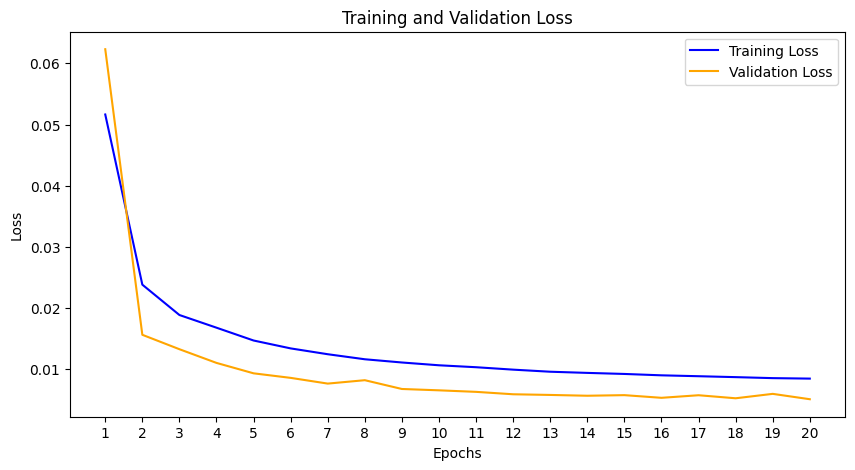

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', color='blue')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(history.history['loss']) + 1))
plt.legend()
plt.show()

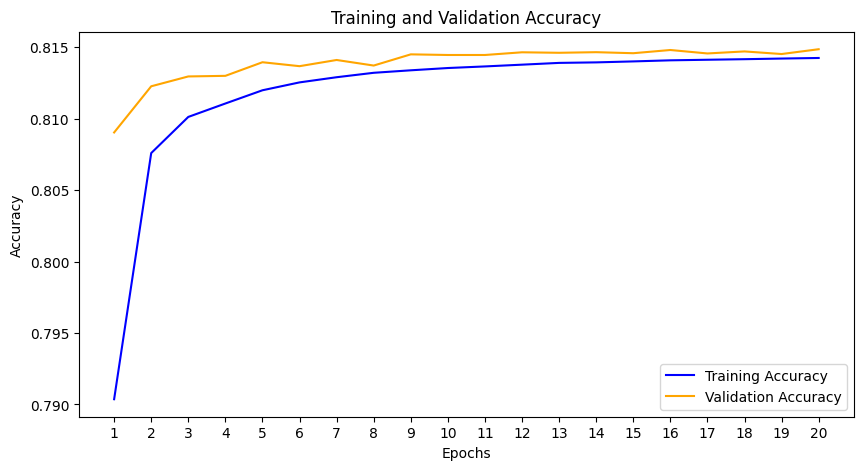

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(history.history['accuracy']) + 1))
plt.legend()
plt.show()

The plots demonstrate a small generalization gap as well as a trend in loss reduction.The regularization terms are only applied while training the model on the training set, inflating the training loss which explains why it ends up being bigger.We also notice how the number of epochs is sufficient since in the last ones there is a tendency for metrics to be stabilized.

**Optimization History**

In [10]:
vis.plot_optimization_history(study)

**Plotting Parameter Importance:**

In [11]:
vis.plot_param_importances(study)

As expected, we notice that the the latent dimension has the biggest influence on the performance, since the bigger it is (30) the bigger the model's capacity to encapsulate information and successfully extract the most important features of the input.A larger number of layers with big filters ([32, 64, 128, 256]) as well is conducive to model's complexity improving the loss score.A rather moderate batch (128) size is being used meaning the weights are being updated more often and generalize better.Since the dataset is not too complex, it can be learned quickly in small number of epochs (20).Lastly, dropout rate is moderate (0.5) leading to more robust representations and better generalization,(using batch normalization reduces the need for dropout too).The model performs well with a rather small batch size and therefore needs a small number of epochs.